<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Data-Set-and-Programming-Problem-Overview" data-toc-modified-id="Data-Set-and-Programming-Problem-Overview-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Set and Programming Problem Overview</a></span></li></ul></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ridge Regression</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-optimization" data-toc-modified-id="Hyperparameter-optimization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter optimization</a></span></li><li><span><a href="#Visualization-of-the-prediction-functions" data-toc-modified-id="Visualization-of-the-prediction-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualization of the prediction functions</a></span></li><li><span><a href="#Sparsity" data-toc-modified-id="Sparsity-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sparsity</a></span></li></ul></li></ul></div>

# Ridge regression

Assignment for the [Foundations of Machine Learning](https://bloomberg.github.io/foml/#about) course.

## Introduction

This notebook implements ridge regression on an artificial dataset.

### Data Set and Programming Problem Overview

- For the experiments, we are generating some artifical data using code in the file `setup_problem.py`
- We are considering the regression setting with the 1-dimensional input space $R$. 
- An image of the training data, along with the target function (i.e. the Bayes prediction function for the square loss function) is shown in the figure below.

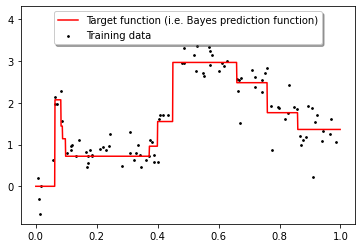

In [1]:
from setup_problem import *
%run setup_problem.py

- The target function is a highly nonlinear function of the input. 
- To handle this sort of problem with linear hypothesis spaces, we will need to create a set of features that perform nonlinear transforms of the input.
- A detailed description of the technique we will use can be found in the Jupyter notebook `basis-fns.ipynb`.

- The function that takes care of the featurization is the “featurize” function, returned by the `generate_problem` function in `setup_problem.py`.
- The `generate_problem` function also gives the true target function, which has been constructed to be a sparse linear combination of our features.
- The coefficients of this linear combination are also provided by `generate_problem`, so you can compare the coefficients of the linear functions you find to the target function coefficients.
- The `generate_problem` function also gives you the train and validation sets that you should use.

## Ridge Regression

The ridge regression objective function is: $$ J(w, \lambda) = \frac{1}{n} \sum_{i=1}^n(w^Tx_i - y_i)^2 + \lambda\|w\|^2   $$

### Hyperparameter optimization
- We run ridge regression on the dataset provided
- We choose $\lambda$ that minimizes the empirical risk (i.e. the average square loss) on the validation set. 

In [2]:
#load the data
x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize = load_problem('lasso_data.pickle')

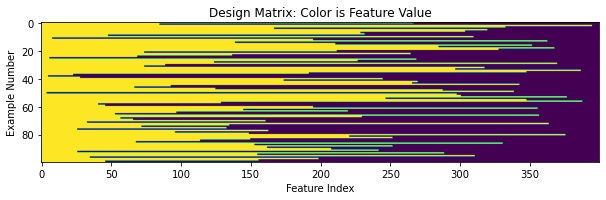

In [3]:
# Generate features
X_train = featurize(x_train)
X_test = featurize(x_test)

#Visualize training data
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)

In [4]:
from ridge_regression import *

#Run ridge regression
ridge_regression_estimator = RidgeRegression(l2reg=1)
ridge_regression_estimator.fit(X_train, y_train)
ridge_weights = ridge_regression_estimator.w_

In [5]:
# Compare our RidgeRegression to sklearn's.
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1)

Hoping this is very close to 0:6.203144003584323e-11


In [6]:
# Do hyperparameter tuning with our ridge regression
grid, results = do_grid_search_ridge(X_train, y_train, X_test, y_test)
print(results)
min_idx = results['mean_test_score'].idxmin()
print('The regression parameter that minimizes test loss was {:.2e}.'.format(results['param_l2reg'][min_idx]))

    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422
The regression parameter that minimizes test loss was 1.00e-02.


Text(0, 0.5, 'Mean Squared Error')

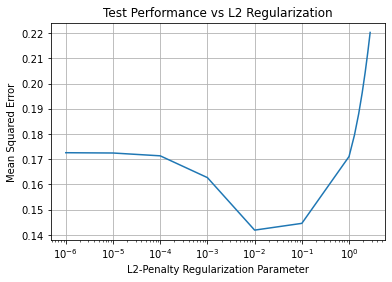

In [7]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Test Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

In [8]:
#Choice of prediction function:
ridge_regression_estimator_chosen = RidgeRegression(l2reg=0.01)
pred_fn = ridge_regression_estimator_chosen.fit(X_train, y_train)
our_coefs = ridge_regression_estimator_chosen.w_

### Visualization of the prediction functions

In [9]:
# Plot prediction functions and compare coefficients for several fits
# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

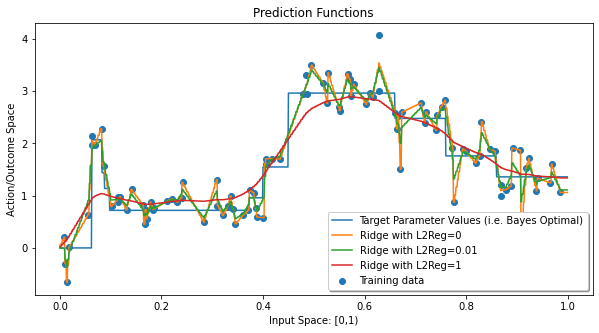

In [10]:
#Plot of training data, target function, and several least square fits

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Input Space: [0,1)')
ax.set_ylabel('Action/Outcome Space')
ax.set_title("Prediction Functions")
plt.scatter(x_train, y_train, label='Training data')
for i in range(len(pred_fns)):
    ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
legend = ax.legend(loc='best', shadow=True)

Next, we visualize the coefficients for each of the prediction functions plotted, including the target function.

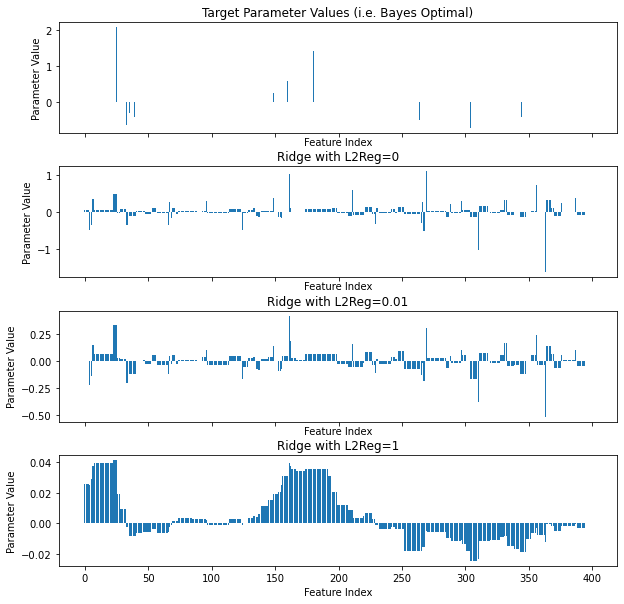

In [11]:
fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(10,10))
num_ftrs = len(pred_fns[0]["coefs"])
for i in range(len(pred_fns)):
    title = pred_fns[i]["name"]
    coef_vals = pred_fns[i]["coefs"]
    axs[i].bar(range(num_ftrs), coef_vals)
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Parameter Value')
    axs[i].set_title(title)

fig.subplots_adjust(hspace=0.3)

The scale of the parameter value decreases with increased $\lambda$ (as expected! The regulation parameter forces the weights to take smaller values.) Features with the most weight are distributed around the indexes of features present in the Bayes Optimal prediction function, and share the same +/- sign.

### Sparsity 

For the chosen λ, we examine the model coefficients.  
For ridge regression, we don’t expect any parameters to be exactly 0. However, let’s investigate whether we can predict the sparsity pattern of the true parameters (i.e. which parameters are 0 and which are nonzero) by thresholding the parameter estimates we get from ridge regression.  
We’ll predict that $w_i = 0$ if $|\hat{w}_i| < \epsilon$ and $w_i \neq 0$ otherwise.  
We will give the confusion matrix for $\epsilon = 10^{−6}, 10^{−3}, 10^{−1}$.

In [12]:
ridge_regression_estimator_chosen = RidgeRegression(l2reg=0.01)
pred_fn = ridge_regression_estimator_chosen.fit(X_train, y_train)
regr_coefs = ridge_regression_estimator_chosen.w_

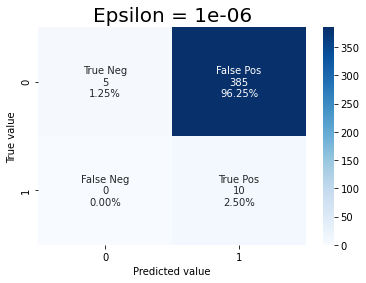

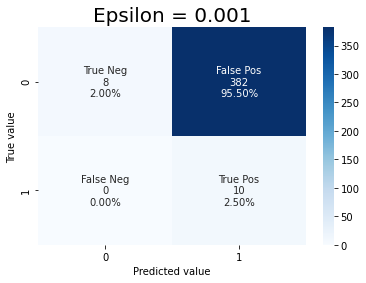

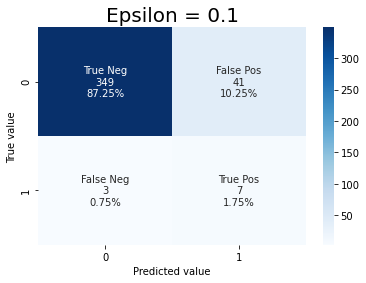

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#transform coefs_true into 0-1 array
true_values = (coefs_true != 0)
true_values = np.multiply(true_values,1)

for epsilon in [1e-6, 1e-3, 1e-1]:
    pred = np.abs(regr_coefs) > epsilon
    pred = np.multiply(pred,1)
    cf_matrix = confusion_matrix(true_values, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title('Epsilon = ' + str(epsilon), fontsize =20)
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.show()

When epsilon increases, we threshold more coefficients to 0, and the proportion of true negatives increases, but so does the rate of false negatives. 